# Importando Bibliotecas

In [34]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import warnings
import os

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

import mnist_loader

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Carregando o MNIST dataset

In [3]:
# Loading MNIST dataset
training_data, validation_data, test_data = mnist_loader.load_data()

X_train, Y_train = np.concatenate((training_data[0], validation_data[0])), np.concatenate((training_data[1], validation_data[1]))
X_test, Y_test = test_data[0], test_data[1]

# Definindo os parâmetros da MLP

Os parâmetros testados em busca do melhor desempenho estão descritos abaixo:
<br>
- Número de camadas: Definido aleatoriamente para cada experimento, de forma que cada MLP testado terá 1 ou mais camadas ocultas, com cada camada sendo adicionada caso o número aleatório retornado pelo random.uniform seja maior do que 0.4
- Número de neurônios: Também definido aleatoriamente para cada experimento e camada, sendo um número entre 2 e 100
- Taxa de aprendizagem: Número definido de forma aleatória entre 0.001 e 0.1, tendo no máximo 4 dígitos
- Função de ativação: Escolhido aleatoriamente, podendo ser 'identity', 'logistic', 'tanh' ou 'relu'
- Algoritmo de aprendizagem: Também escolhido aleatoriamente, podendo ser 'adam' (Adaptive Moment Estimation), 'sgd' (Stochastic Gradient Descent) ou 'lbfgs' (Limited-memory Broyden-Fletcher-Goldfarb-Shanno)

In [10]:
def random_hidden_layers(max_hidden_layer=100, hidden_layer_prob=0.4):
    """
    Gera aleatoriamente o número de camadas escondidas para uma rede neural Multilayer Perceptron (MLP).

    Parâmetros:
    - max_hidden_layer: Número máximo de neurônios em uma camada escondida.
    - hidden_layer_prob: Probabilidade de adicionar uma camada escondida adicional.

    Retorna:
    - hidden_layer: Uma lista representando o número de neurônios em cada camada escondida.
    """
    hidden_layer = [random.randint(2, max_hidden_layer)]
    while random.uniform(0.0, 1.0) > hidden_layer_prob:
        hidden_layer.append(random.randint(2, 100))
    return hidden_layer

def random_params_mlp(verbose=False, num_epochs=1000, tol=0.0001):
    """
    Gera aleatoriamente os parâmetros para uma rede neural Multilayer Perceptron (MLP).

    Parâmetros:
    - verbose: Se True, mostrar mensagens de progresso durante o treinamento.
    - num_epochs: Número máximo de épocas de treinamento.
    - tol: Tolerância para a otimização.

    Retorna:
    - MLPClassifier: Um classificador MLP com parâmetros aleatórios.
    """
    return MLPClassifier(
        activation=random.choice(['identity', 'logistic', 'tanh', 'relu']),
        batch_size='auto',
        early_stopping=True,
        hidden_layer_sizes=random_hidden_layers(),
        learning_rate_init=round(random.uniform(0.0001, 0.1), 4),
        max_iter=num_epochs,
        n_iter_no_change=3,
        solver=random.choice(['adam', 'sgd', 'lbfgs']),
        tol=tol,
        verbose=verbose,
        warm_start=True
    )

# Fazendo um "GridSearch" sobre a camada escondida

Primeiro vamos definir a estrutura do dataframe para armazenar os resultados obtidos durante o gridsearch

In [8]:
if (os.path.exists('model_metrics.csv')):
    model_df = pd.read_csv('model_metrics.csv')
else:
    model_data = {
        'solver': [],
        'activation_function': [],
        'hidden_layers': [],
        'learning_rate': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'fit_time': [],
        'total_epochs': [],
    }
    model_df = pd.DataFrame(model_data)

Em seguida, realizamos 10 experimentos, cada um com parâmetros diferentes escolhidos aleatoriamente usando a biblioteca random, que é nativa do python. Para cada experimento, iremos exibir a acurácia total e tempo de treinamento do modelo testado, além de salvar seus resultados (acurácia total, precisão total, recall total, tempo de treinamento e f1 score) e parâmetros (função de ativação, algoritmo de aprendizagem, número de epochs, número de camadas e neurônios e taxa de aprendizagem).
<br>No final de cada experimento, são salvos os três modelos com a maior acurácia total, os quais são exibidos após a conclusão de todos os 10 testes.

In [11]:
trained_models = []

print("Activation | Solver | LR | Hidden Layers | Total Time | Total Epochs -> Accuracy")
for _ in range(10):
    mlp = random_params_mlp(num_epochs=250)

    start = time.time()
    mlp.fit(X_train, Y_train)
    end = time.time()
    total_time = round(end - start, 1)

    mlp_predictions = mlp.predict(X_test)
    accuracy = accuracy_score(Y_test, mlp_predictions)
    precision = precision_score(Y_test, mlp_predictions, average='macro')
    recall = recall_score(Y_test, mlp_predictions, average='macro')
    f1 = f1_score(Y_test, mlp_predictions, average='macro')
    print(f"{mlp.get_params()['activation']} | {mlp.get_params()['solver']} | {mlp.get_params()['learning_rate_init']} \
| {mlp.get_params()['hidden_layer_sizes']} | {total_time}s | {mlp.n_iter_} -> {accuracy}")

    trained_models.append((mlp, accuracy))
    trained_models = sorted(trained_models, key=lambda tup: tup[1], reverse=True)[:3]

    # Adicionando o modelo ao dataframe de modelos
    model_df.loc[len(model_df)] = {
        'solver': mlp.get_params()['solver'],
        'activation_function': mlp.get_params()['activation'],
        'hidden_layers': str(mlp.get_params()['hidden_layer_sizes']),
        'learning_rate': mlp.get_params()['learning_rate_init'],
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'fit_time': total_time,
        'total_epochs': mlp.n_iter_,
    }

    model_df.to_csv('model_metrics.csv', index=False)

print("\nTop 3 Models:")
for model, acc in trained_models:
    print(f"Accuracy: {acc}, Params: {model.get_params()['hidden_layer_sizes']}")

Activation | Solver | LR | Hidden Layers | Total Time | Total Epochs -> Accuracy
relu | sgd | 0.0626 | [55] | 21.8s | 21 -> 0.9737
logistic | lbfgs | 0.0242 | [56, 26] | 167.4s | 305 -> 0.9602
logistic | adam | 0.0569 | [54, 80] | 14.6s | 11 -> 0.9387
relu | adam | 0.0415 | [42, 99, 77, 85, 2, 89] | 8.9s | 5 -> 0.1135
tanh | lbfgs | 0.0509 | [33, 65] | 92.4s | 188 -> 0.9623
tanh | sgd | 0.0347 | [87] | 12.1s | 23 -> 0.9761
logistic | lbfgs | 0.0133 | [94, 100, 70] | 236.9s | 276 -> 0.9672
tanh | adam | 0.0334 | [19, 96] | 7.7s | 9 -> 0.9263
logistic | sgd | 0.0881 | [70, 9] | 26.9s | 31 -> 0.9751
tanh | sgd | 0.0726 | [47, 46, 78, 71, 98, 43, 90] | 15.7s | 10 -> 0.9684
identity | sgd | 0.0239 | [71, 81] | 9.5s | 16 -> 0.9226
relu | adam | 0.0203 | [23, 33, 43, 6] | 15.4s | 24 -> 0.9171
identity | sgd | 0.0623 | [39, 64, 52] | 2.9s | 7 -> 0.9174
tanh | adam | 0.0788 | [22] | 5.7s | 18 -> 0.9115
logistic | lbfgs | 0.0618 | [58, 43, 34, 60, 38, 78] | 5.6s | 5 -> 0.1135
identity | adam | 0

In [68]:
model_df

,solver,activation_function,hidden_layers,learning_rate,accuracy,precision,recall,f1_score,fit_time,total_epochs
0,adam,identity,[61],0.0569,0.8742,0.876358,0.872339,0.871276,3.2,5
1,lbfgs,tanh,[4],0.0837,0.6320,0.606148,0.623954,0.565305,3.0,27
2,sgd,relu,[44],0.0144,0.9480,0.947412,0.947468,0.947383,2.6,7
3,adam,tanh,[86],0.0551,0.9204,0.922603,0.919487,0.919357,3.1,5
4,adam,logistic,"[13, 10]",0.0392,0.9145,0.913521,0.912945,0.912941,1.7,6
5,sgd,logistic,"[3, 43, 92, 56, 82]",0.0166,0.1135,0.011350,0.100000,0.020386,4.3,6
6,adam,relu,"[16, 69, 52]",0.0084,0.9548,0.954890,0.954328,0.954229,2.6,5
7,lbfgs,relu,"[5, 27]",0.0590,0.7302,0.730097,0.725420,0.725255,21.1,159
8,sgd,logistic,"[60, 54, 89, 71, 86]",0.0618,0.1032,0.010320,0.100000,0.018709,5.6,5
9,adam,identity,"[86, 71]",0.0880,0.9074,0.908315,0.905416,0.905387,5.7,9


In [ ]:
model_df.to_csv('model_metrics.csv', index=False)

Acima temos os parâmetros para cada um dos 25 Multilayer Perceptrons testados, junto com sua acurácia total e o tempo que levou para treinar cada um deles. <br>
Nota-se que a maioria dos modelos apresentam uma acurácia parecida, com excessão de alguns modelos que possuem 4 camadas ocultas, com o restante dos modelos apresentando uma acurácia total maior do que 0.89.

# Análise da Performance Sobre o Conjunto de Teste

In [69]:
best_model = trained_models[0][0]

In [70]:
mlp_predictions = best_model.predict(X_test)

## Calculando Acurácia, Precisão e Recall

Feita a previsão do modelo com os dados do conjunto de teste, foi calculado a acurácia, precisão, recall total e f1 score  usando as funções accuracy_score, precision_score, recall_score e f1_score, todos da biblioteca scikit-learn.

In [71]:
accuracy = accuracy_score(Y_test, mlp_predictions)
precision = precision_score(Y_test, mlp_predictions, average='macro')
recall = recall_score(Y_test, mlp_predictions, average='macro')
f1 = f1_score(Y_test, mlp_predictions, average='macro')

In [72]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9761
Precision: 0.976080279947307
Recall: 0.9758857555893016
F1 Score: 0.9759628918407467


Além disso, exibimos as principais métricas de classificação (acurácia, precisão, recall e f1 score) para cada classe para que possamos avaliar a confiabilidade do modelo na classificação de cada dígito.

In [79]:
#Pegando o report de cada classe 
report = classification_report(Y_test, mlp_predictions, target_names=['0','1','2','3','4','5','6','7','8','9'], output_dict = True)
conf_matrix = confusion_matrix(Y_test, mlp_predictions )
# Calcular a acurácia para cada classe
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i in range(10):
  report[str(i)]['accuracy'] = accuracy_per_class[i]

#Printando a tabela
infoClass = pd.DataFrame(report)
infoClass = infoClass.drop(columns=['accuracy', 'macro avg', 'weighted avg'])
infoClass

,0,1,2,3,4,5,6,7,8,9
precision,0.974925,0.985101,0.977670,0.965720,0.982564,0.981839,0.976091,0.971652,0.974039,0.971202
recall,0.991837,0.990308,0.975775,0.976238,0.975560,0.969731,0.980167,0.966926,0.963039,0.969277
f1-score,0.983308,0.987698,0.976722,0.970950,0.979050,0.975747,0.978125,0.969283,0.968508,0.970238
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000
accuracy,0.991837,0.990308,0.975775,0.976238,0.975560,0.969731,0.980167,0.966926,0.963039,0.969277


## Plotando a Matrix de Confusão

Também exibimos a matriz de confusão abaixo, fornecendo uma outra visão da performance do melhor modelo para cada uma das suas 10 classes, de forma a avaliarmos a quantidade de instâncias de cada classe que o modelo classificou corretamente.

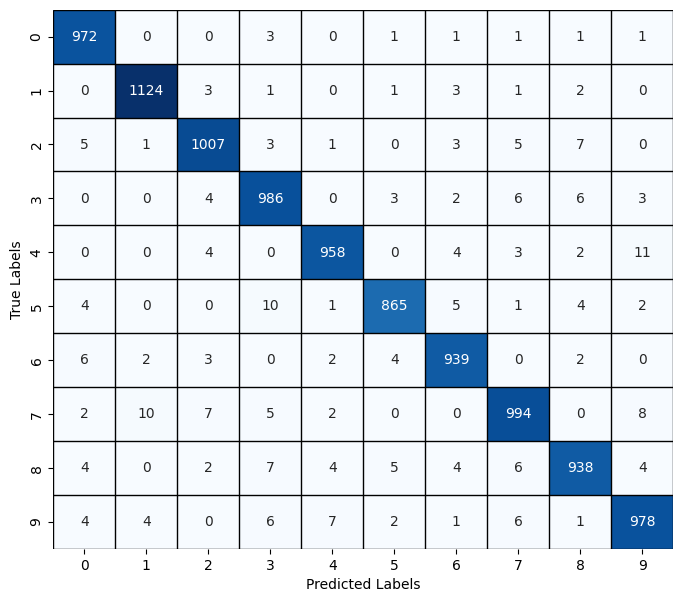

In [74]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, mlp_predictions)
plt.figure(figsize=(8, 7))

# Heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=range(10), yticklabels=range(10))

# Labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(11):
    plt.hlines(i, xmin=0, xmax=10, colors='black', linestyles='solid', linewidth=1)
    plt.vlines(i, ymin=0, ymax=10, colors='black', linestyles='solid', linewidth=1)

plt.show()

Observa-se que o modelo tem uma performance boa em todas as classes, acertando a maioria dos casos de teste, errando principalmente os dígitos 8 e 9, onde mais de 30 instâncias foram classificadas incorretamente, porém com mais de 900 instâncias, para cada um desses dígitos, sendo classificadas corretamente.

## Média e Desvio Padrão das Métricas

Por último, iremos calcular a média e desvio padrão dos 3 melhores conjuntos de parâmetros para ter um melhor entendimento do quão bom é a performance dos modelos treinados com esses parâmetros.

In [75]:
data = {
    'Params': [],
    'Mean Accuracy': [],
    'Std Accuracy': [],
    'Mean Precision': [],
    'Std Precision': [],
    'Mean Recall': [],
    'Std Recall': [],
    'Mean Time': [],
    'Std Time': [],
}

In [76]:
# Criando 10 modelos para as 3 melhores combinações de parâmetros
for i, model in enumerate(trained_models):
    model = model[0]
    accuracy = []
    precision = []
    recall = []
    fit_time = []
    for _ in range(10):
        start = time.time()
        model.fit(X_train, Y_train)
        end = time.time()
        fit_time.append(round(end - start, 1))

        model_predictions = model.predict(X_test)
        accuracy.append(accuracy_score(Y_test, model_predictions))
        precision.append(precision_score(Y_test, model_predictions, average='weighted'))
        recall.append(recall_score(Y_test, model_predictions, average='weighted'))

    data['Params'].append(f"C{i}")
    data['Mean Accuracy'].append(np.mean(accuracy))
    data['Std Accuracy'].append(np.std(accuracy))
    data['Mean Precision'].append(np.mean(precision))
    data['Std Precision'].append(np.std(precision))
    data['Mean Recall'].append(np.mean(recall))
    data['Std Recall'].append(np.std(recall))
    data['Mean Time'].append(np.mean(fit_time))
    data['Std Time'].append(np.std(fit_time))
df = pd.DataFrame(data)

In [77]:
df

,Params,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean Time,Std Time
0,C0,0.97703,0.000930,0.977057,0.000937,0.97703,0.000930,2.21,1.571273
1,C1,0.97508,0.000711,0.975148,0.000669,0.97508,0.000711,2.44,1.952537
2,C2,0.97569,0.000413,0.975736,0.000410,0.97569,0.000413,1.22,0.843564


# Salvando o melhor modelo treinado

Nessa secção está o código para salvar o modelo de melhor performance usando o pickle, outra biblioteca nativa do python.
<br>Salvamos esse modelo em um arquivo .pkl que pode ser aberto posteriormente com o pickle.load(open(caminho_arquivo_pkl, 'rb')).

In [ ]:
filename = 'test_model.plk'

In [ ]:
# Salvando o modelo em um arquivo
with open(filename, 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
# # Carregando um modelo salvo
# with open(filename, 'rb') as f:
#     best_model = pickle.load(f)

In [91]:
data = pd.read_csv('model_metrics_100_0001.csv')
data2 = pd.read_csv('model_metrics_500_0.01.csv')
data3 = pd.read_csv('model_metrics_500_00001.csv')
data4 = pd.read_csv('model_metrics.csv')

In [92]:
df = pd.concat([data, data2, data3, data4], ignore_index=True)

In [93]:
df

,solver,activation_function,hidden_layers,learning_rate,accuracy,precision,recall,f1_score,fit_time,total_epochs
0,sgd,logistic,"[64, 19, 4, 79, 99, 76, 19, 69]",0.0711,0.1135,0.011350,0.100000,0.020386,9.9,7
1,sgd,relu,"[77, 33, 70, 65]",0.0021,0.9677,0.967661,0.967316,0.967425,27.8,38
2,lbfgs,relu,"[78, 17, 68]",0.0198,0.9619,0.961637,0.961626,0.961597,54.1,100
3,lbfgs,tanh,[55],0.0802,0.9623,0.962036,0.961995,0.961984,40.2,100
4,adam,logistic,[53],0.0391,0.9606,0.960712,0.960235,0.960381,7.1,13
...,...,...,...,...,...,...,...,...,...,...
222,sgd,identity,[13],0.0426,0.9240,0.923023,0.923075,0.922962,5.2,19
223,adam,tanh,"[7, 82]",0.0799,0.8526,0.850527,0.850165,0.849668,3.4,9
224,lbfgs,tanh,"[98, 14, 88, 45, 23, 21]",0.0116,0.9689,0.968756,0.968445,0.968537,168.5,250
225,lbfgs,tanh,"[48, 69, 33, 86]",0.0866,0.9699,0.969743,0.969501,0.969611,85.7,140


In [94]:
result = df.sort_values(['accuracy'], ascending=False)
result

,solver,activation_function,hidden_layers,learning_rate,accuracy,precision,recall,f1_score,fit_time,total_epochs
17,sgd,tanh,"[88, 82, 48]",0.0604,0.9795,0.979310,0.979242,0.979241,13.2,17
200,lbfgs,relu,[91],0.0790,0.9766,0.976579,0.976383,0.976470,82.1,188
145,sgd,tanh,[89],0.0812,0.9762,0.976047,0.975991,0.976001,11.3,18
194,sgd,relu,"[96, 55]",0.0688,0.9762,0.976022,0.975989,0.975961,12.1,16
80,sgd,tanh,[87],0.0347,0.9761,0.976080,0.975886,0.975963,12.1,23
...,...,...,...,...,...,...,...,...,...,...
73,lbfgs,logistic,"[81, 11, 52]",0.0073,0.1135,0.011350,0.100000,0.020386,1.5,1
89,lbfgs,logistic,"[58, 43, 34, 60, 38, 78]",0.0618,0.1135,0.011350,0.100000,0.020386,5.6,5
0,sgd,logistic,"[64, 19, 4, 79, 99, 76, 19, 69]",0.0711,0.1135,0.011350,0.100000,0.020386,9.9,7
58,sgd,logistic,"[60, 54, 89, 71, 86]",0.0618,0.1032,0.010320,0.100000,0.018709,5.6,5


### Acurácia x Total de Épocas

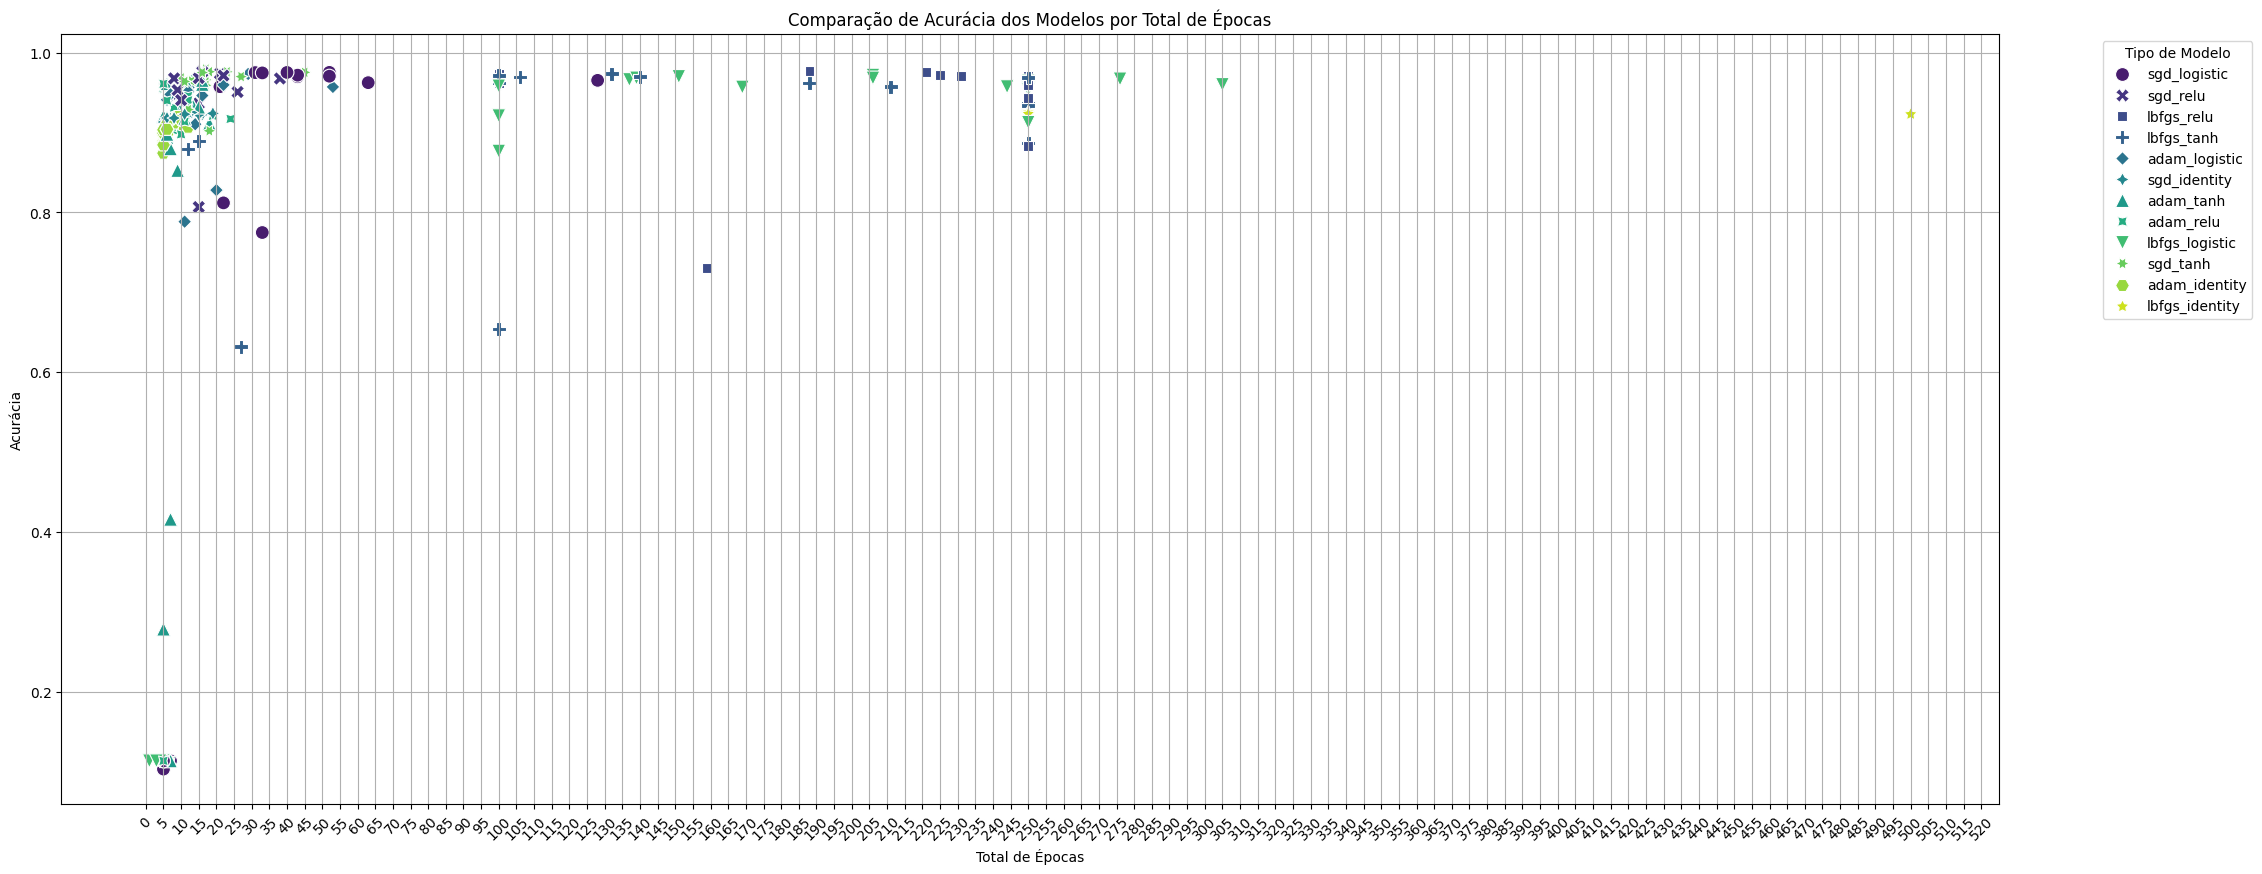

In [95]:
plt.figure(figsize=(25, 10))
df['model_type'] = df['solver'] + '_' + df['activation_function']

sns.scatterplot(data=df, x='total_epochs', y='accuracy', hue='model_type', style='model_type', markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Total de Épocas')
plt.xlabel('Total de Épocas')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ticks=range(0, 525, 5))
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()

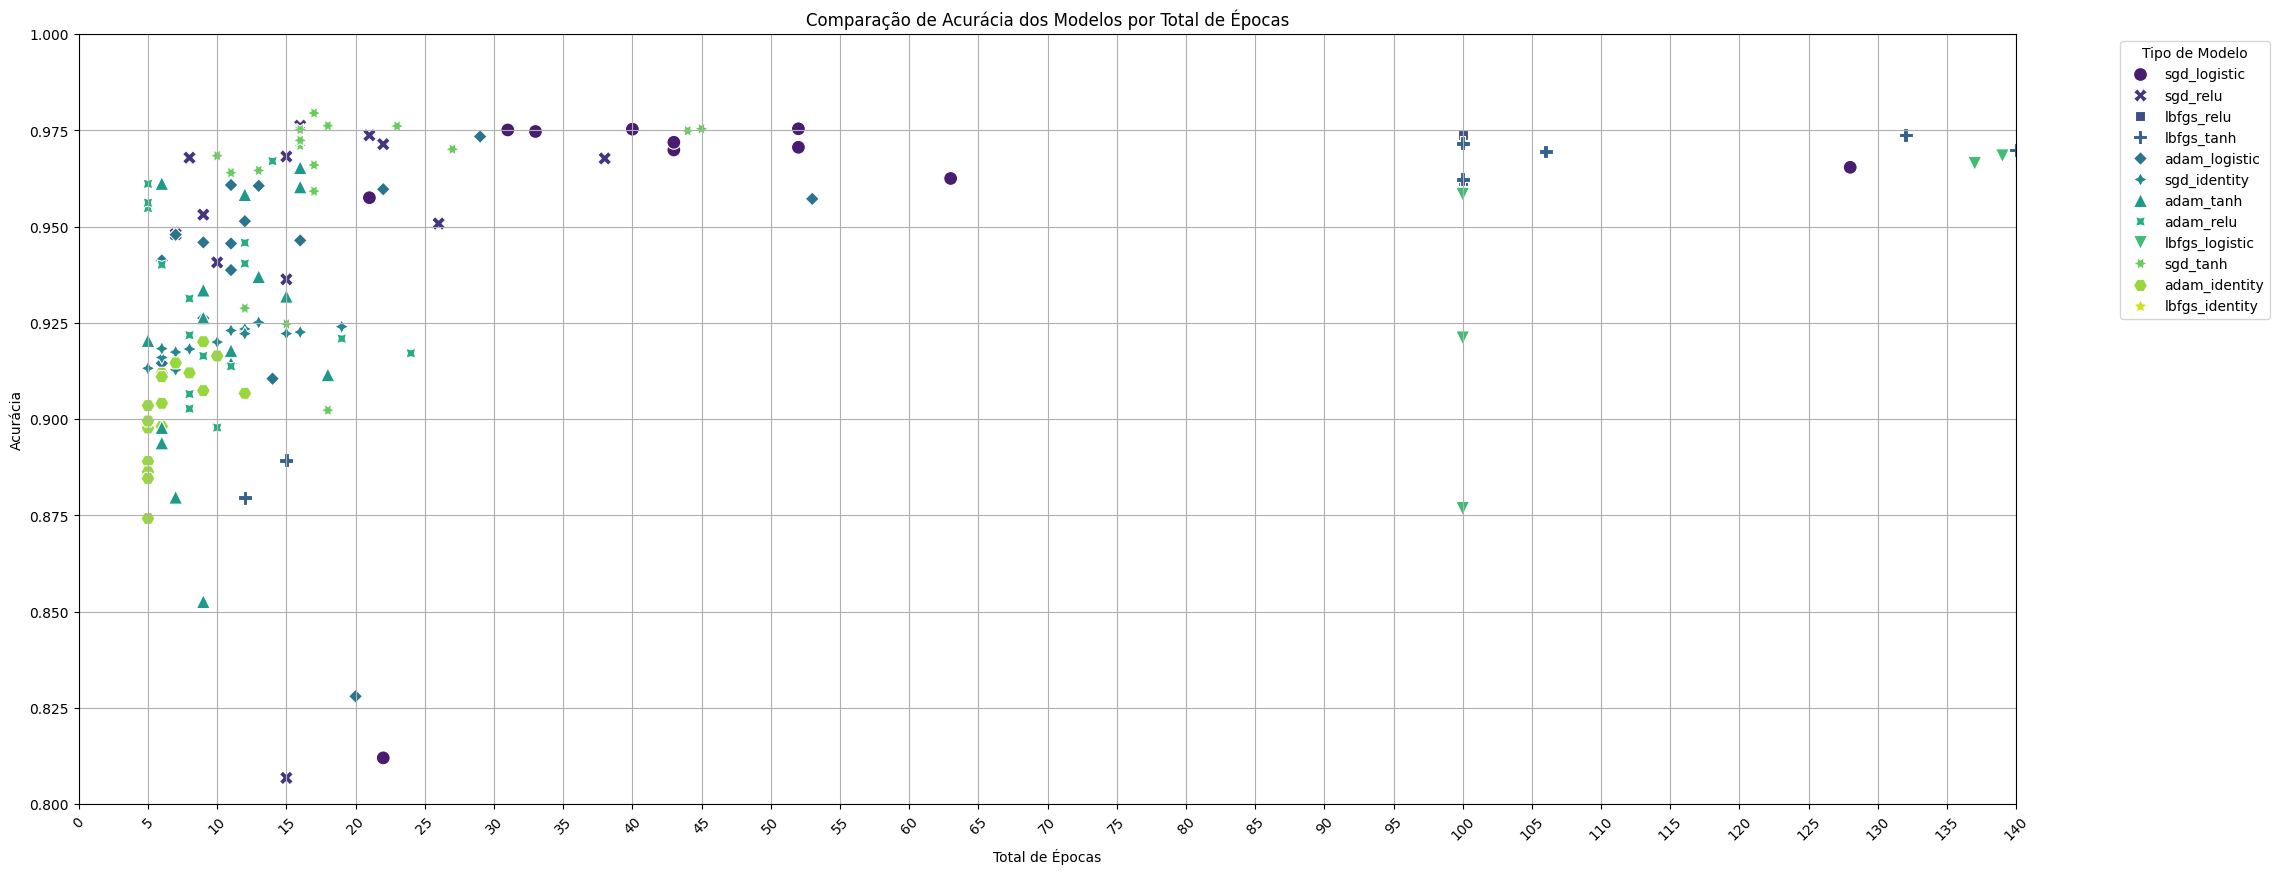

In [96]:

plt.figure(figsize=(25, 10))
df['model_type'] = df['solver'] + '_' + df['activation_function']

sns.scatterplot(data=df, x='total_epochs', y='accuracy', hue='model_type', style='model_type', markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Total de Épocas')
plt.xlabel('Total de Épocas')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ticks=range(0, 525, 5))
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left') 


plt.xlim(0, 140)  
plt.ylim(0.8, 1.0) 

plt.show()

### Acurácia x Quantidade Total de Neurônios

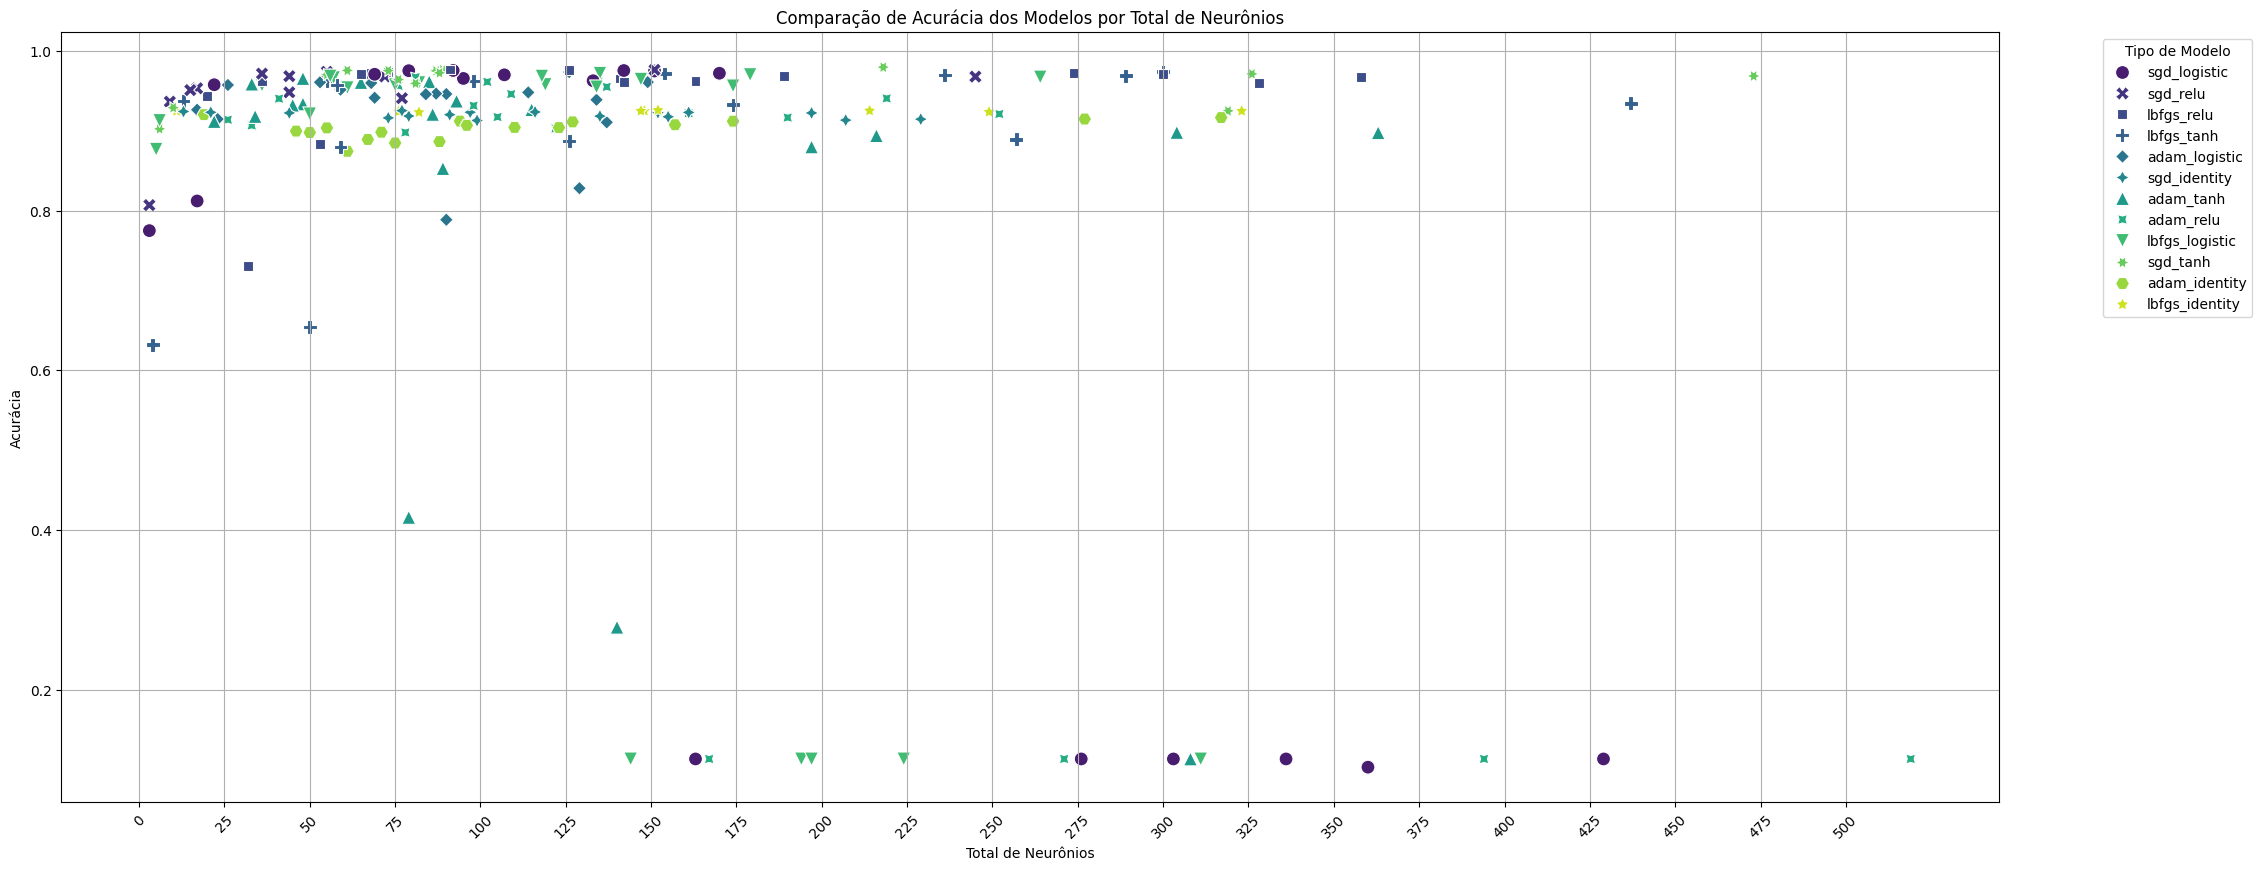

In [97]:
df['total_neurons'] = df['hidden_layers'].apply(lambda x: sum(eval(x)))

plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.scatterplot(data=df, x='total_neurons', y='accuracy', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)  # Ajustando o tamanho dos pontos para melhor visualização

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Total de Neurônios')
plt.xlabel('Total de Neurônios')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ticks=range(0, 525, 25))
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()


### Acurácia x Número de Camadas

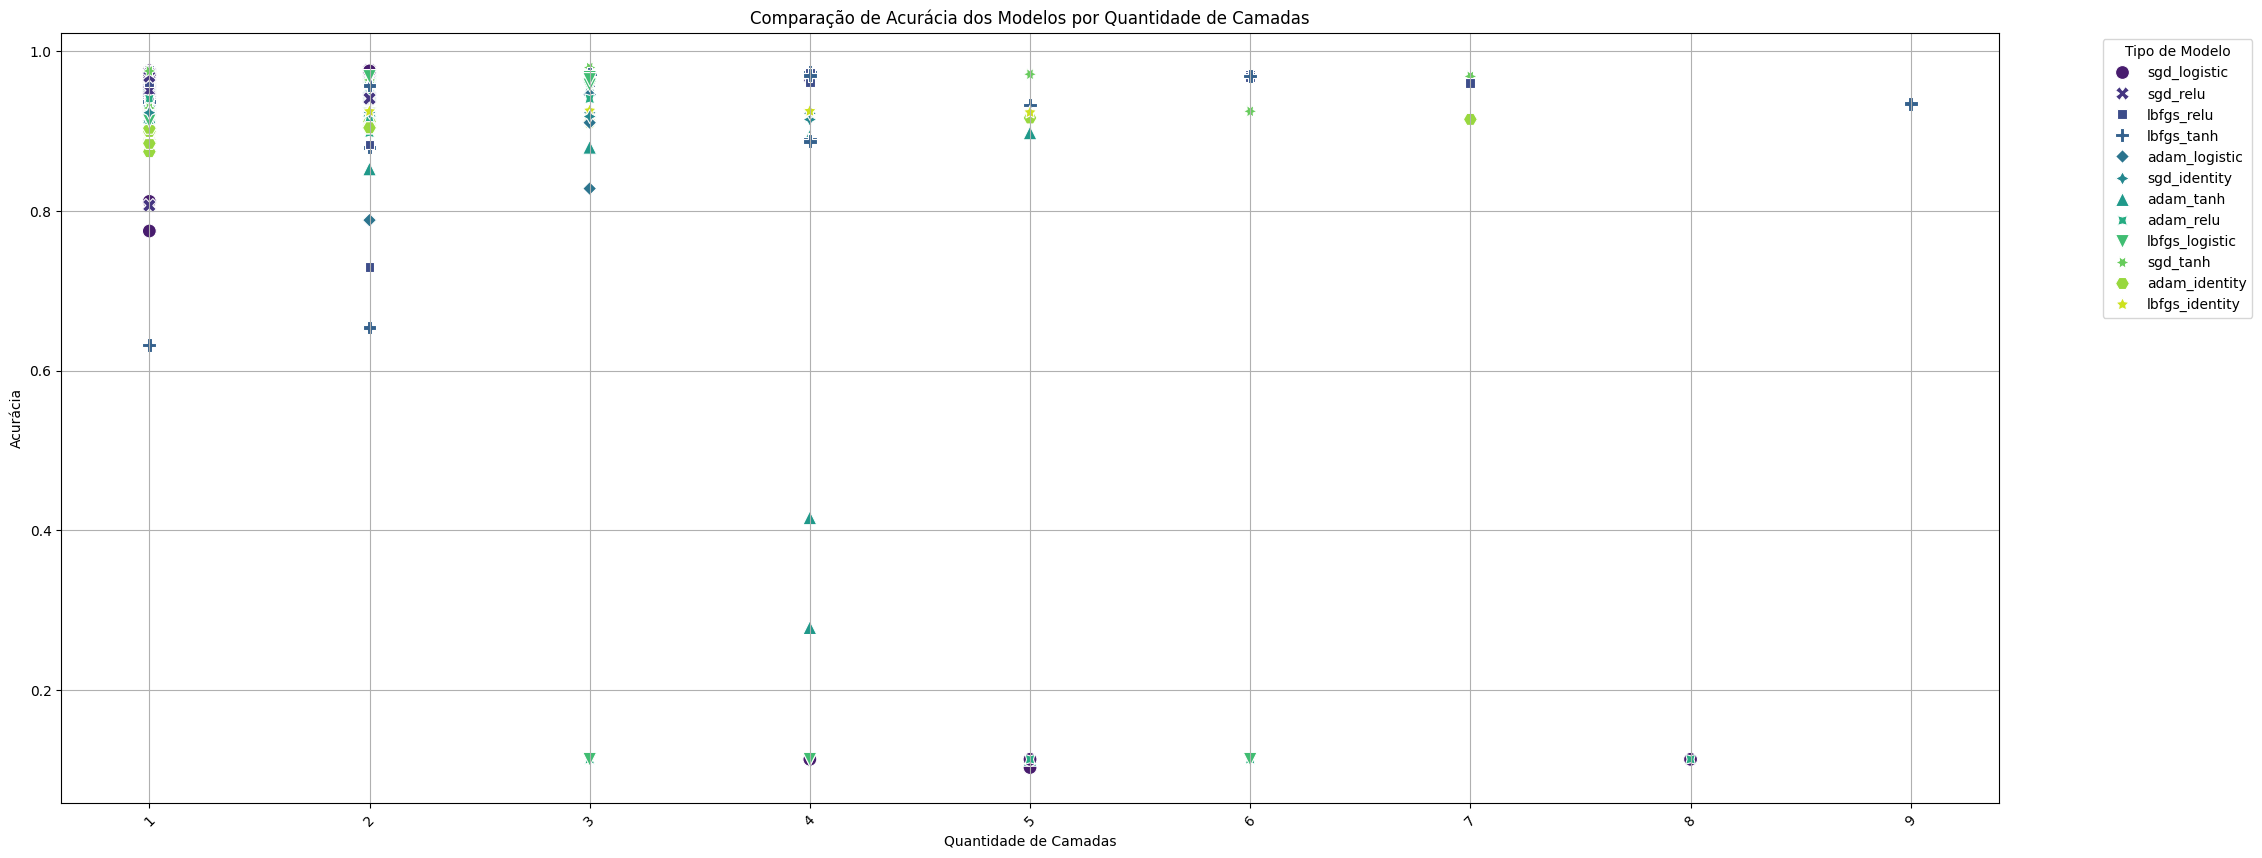

In [98]:
df['num_layers'] = df['hidden_layers'].apply(lambda x: len(eval(x)))

plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.scatterplot(data=df, x='num_layers', y='accuracy', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)  # Ajustando o tamanho dos pontos para melhor visualização

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Quantidade de Camadas')
plt.xlabel('Quantidade de Camadas')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()


### Acurácia x Learning Rate

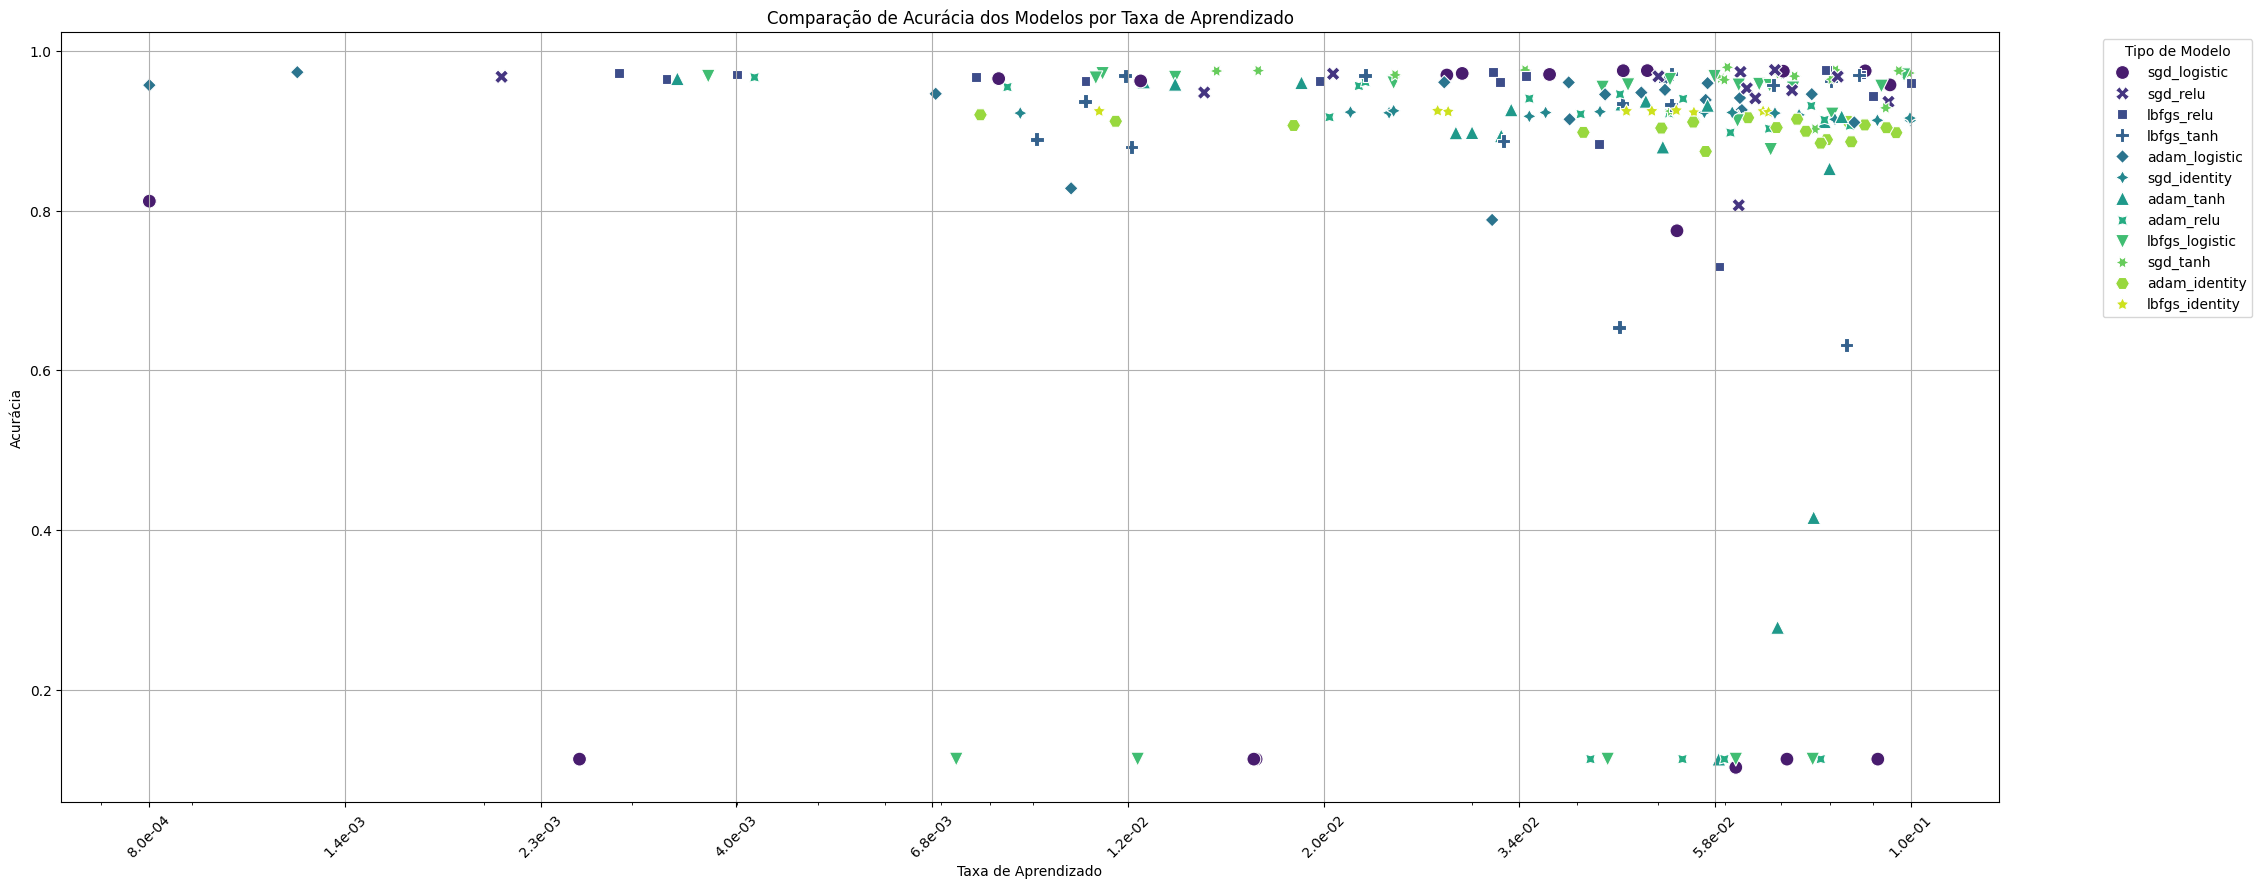

In [99]:
plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.scatterplot(data=df, x='learning_rate', y='accuracy', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Taxa de Aprendizado')
plt.xlabel('Taxa de Aprendizado')
plt.ylabel('Acurácia')
plt.xscale('log')  
# Ajustando os ticks do eixo x para maior granularidade
min_lr = df['learning_rate'].min()
max_lr = df['learning_rate'].max()
ticks = np.logspace(np.log10(min_lr), np.log10(max_lr), num=10)  
plt.xticks(ticks, labels=[f"{x:.1e}" for x in ticks])  
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.show()


## Verificando a acurácia por classe do melhor modelo

In [103]:
infoClass = infoClass.transpose()

In [104]:
infoClass

,precision,recall,f1-score,support,accuracy
0,0.974925,0.991837,0.983308,980.0,0.991837
1,0.985101,0.990308,0.987698,1135.0,0.990308
2,0.977670,0.975775,0.976722,1032.0,0.975775
3,0.965720,0.976238,0.970950,1010.0,0.976238
4,0.982564,0.975560,0.979050,982.0,0.975560
5,0.981839,0.969731,0.975747,892.0,0.969731
6,0.976091,0.980167,0.978125,958.0,0.980167
7,0.971652,0.966926,0.969283,1028.0,0.966926
8,0.974039,0.963039,0.968508,974.0,0.963039
9,0.971202,0.969277,0.970238,1009.0,0.969277


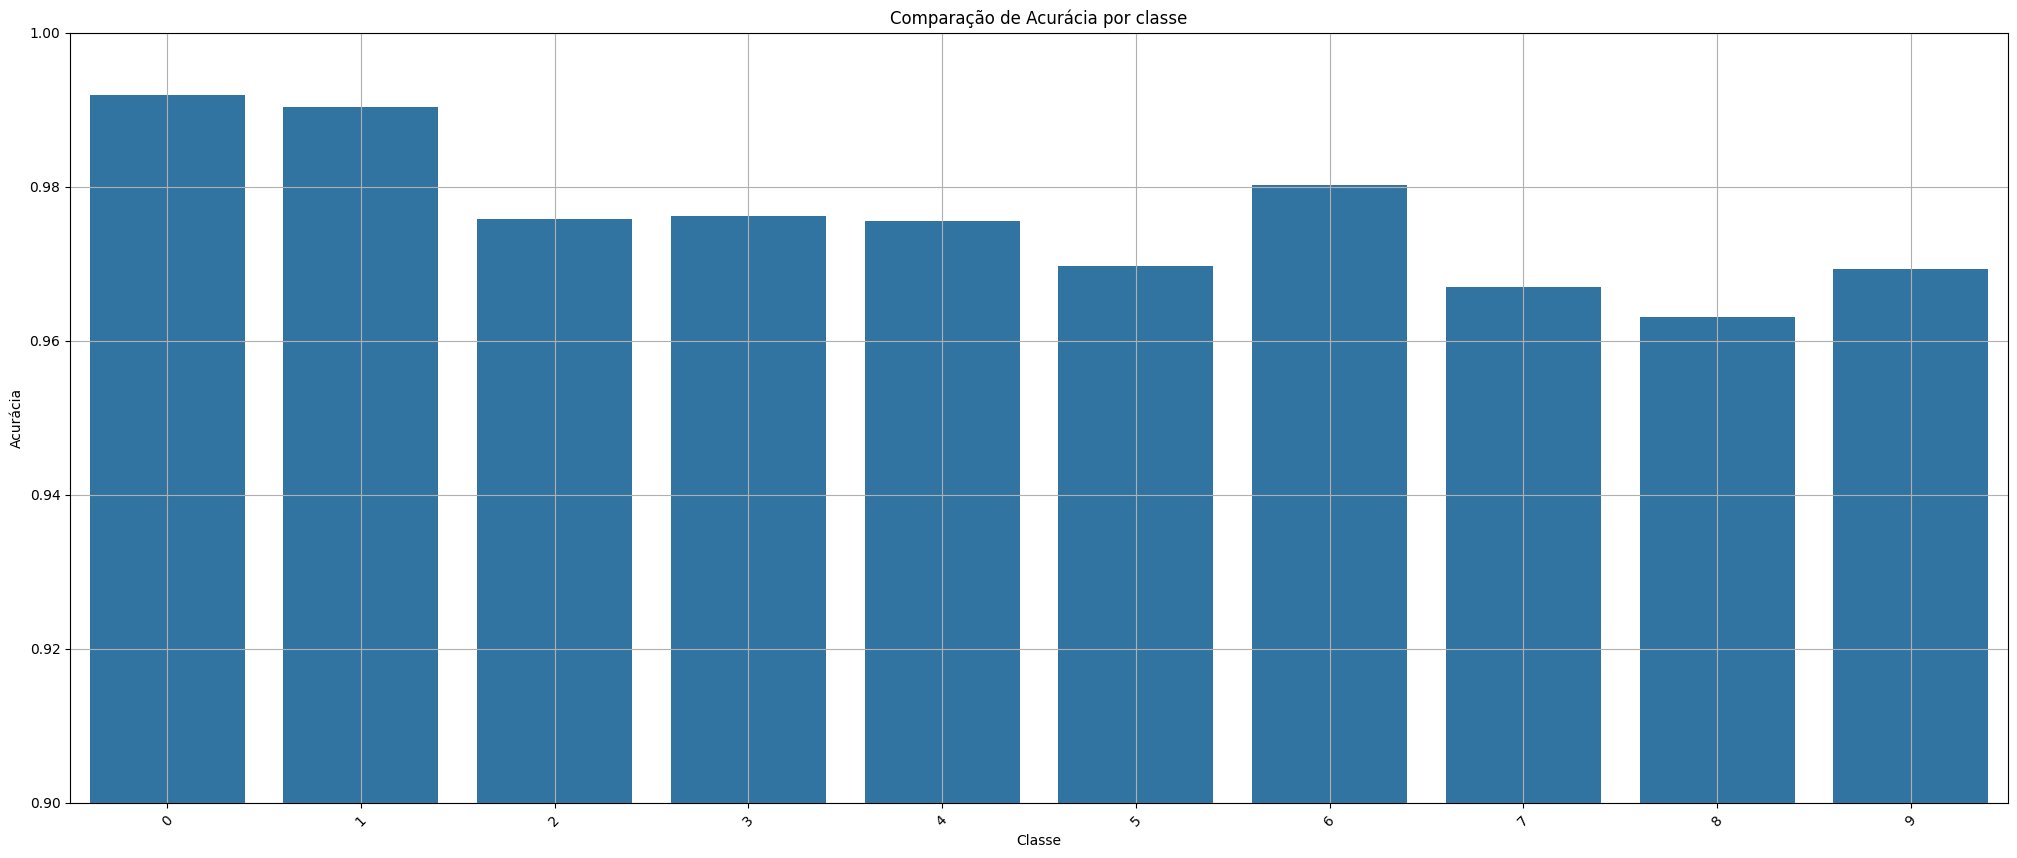

In [105]:
plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.barplot(data=infoClass, x=infoClass.index, y='accuracy')

# Personalizando o gráfico
plt.title('Comparação de Acurácia por classe')
plt.xlabel('Classe')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.grid(True)

plt.ylim(0.9, 1.0) 

plt.show()



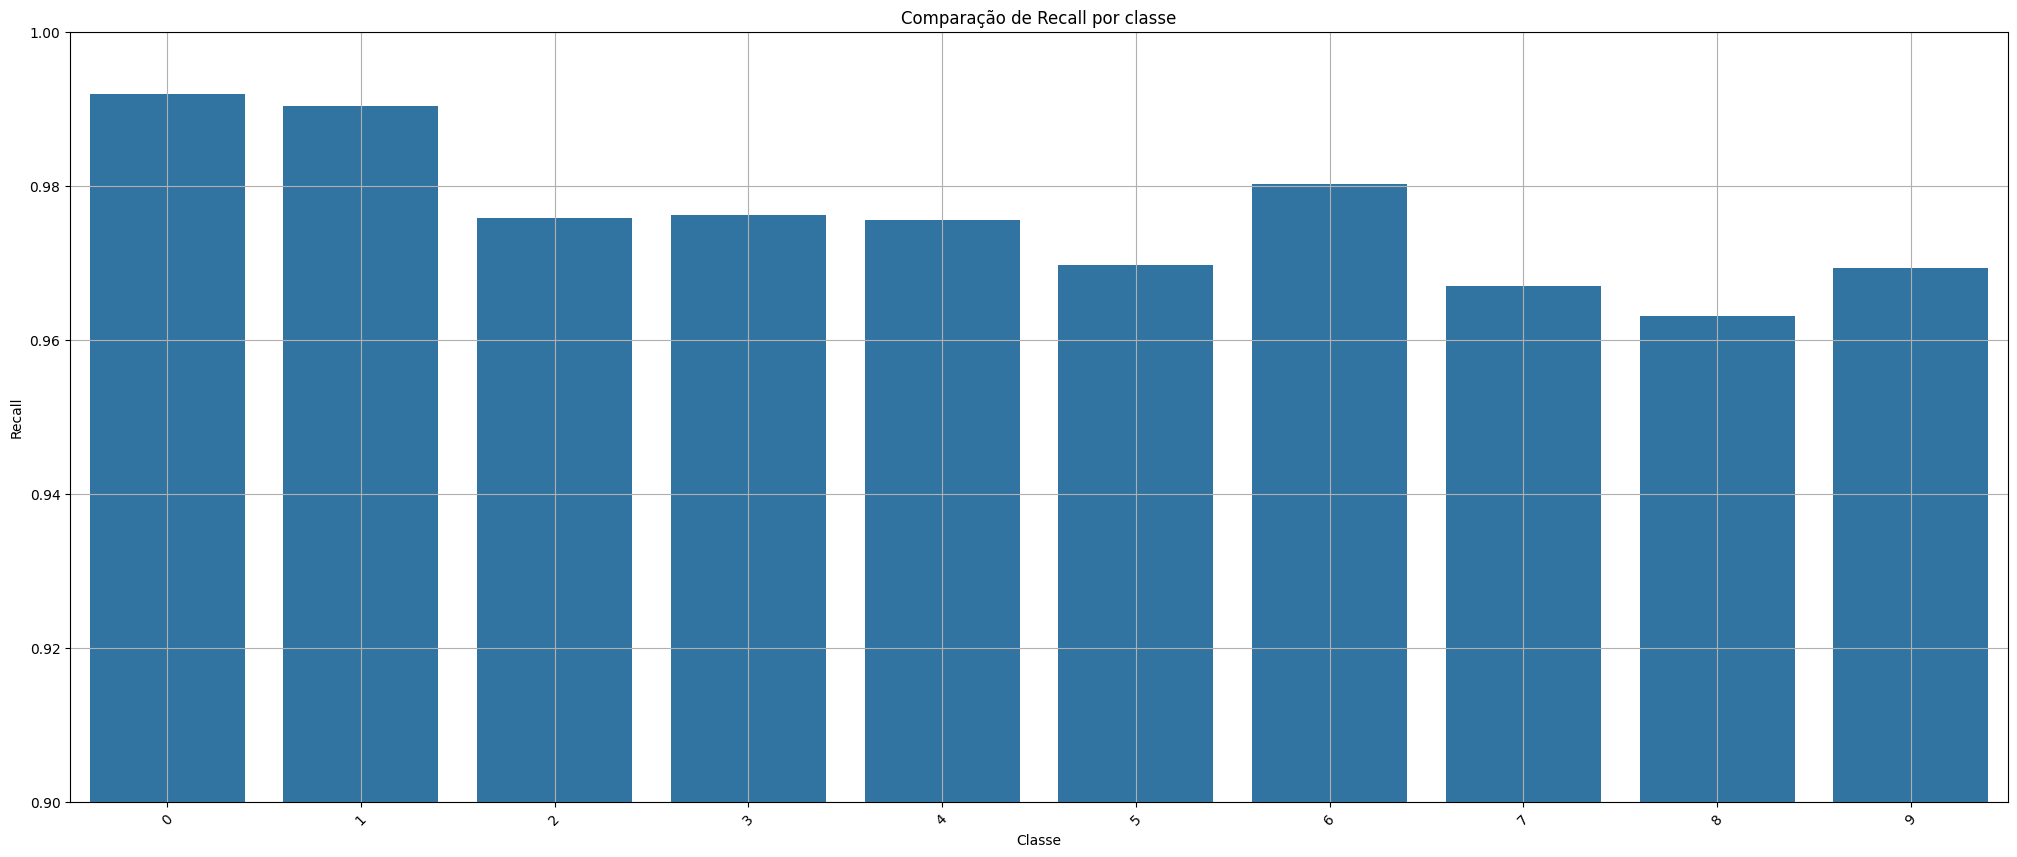

In [106]:
plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.barplot(data=infoClass, x=infoClass.index, y='recall')

# Personalizando o gráfico
plt.title('Comparação de Recall por classe')
plt.xlabel('Classe')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.grid(True)

plt.ylim(0.9, 1.0) 

plt.show()

